# Import

In [115]:
import os
import datetime
import pandas as pd
from matplotlib import pyplot as plt
import yfinance as yf

In [116]:
# If File Exists Then Read File Else Convert sp500 To CSV
if os.path.exists("/Users/tgut03/Jupyter/Data/sp500.csv") :
    sp500 = pd.read_csv("/Users/tgut03/Jupyter/Data/sp500.csv", index_col = 0)
else :
    sp500 = yf.Ticker("^GSPC")
    sp500 = sp500.history(period = "max")
    sp500.to_csv("/Users/tgut03/Jupyter/Data/sp500.csv")

# Process

In [117]:
# Convert Data Types
sp500.index = pd.to_datetime(sp500.index, utc = True)
sp500.index = sp500.index.date

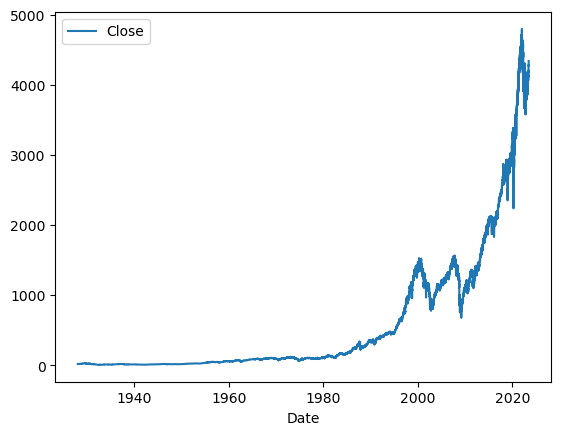

In [118]:
# Line Chart
sp500.plot(kind = "line", y = "Close", use_index = True)
plt.xlabel("Date")
plt.show()

In [119]:
# Remove Variables
del sp500["Dividends"]
del sp500["Stock Splits"]
sp500

,Open,High,Low,Close,Volume
1927-12-30,17.660000,17.660000,17.660000,17.660000,0
1928-01-03,17.760000,17.760000,17.760000,17.760000,0
1928-01-04,17.719999,17.719999,17.719999,17.719999,0
1928-01-05,17.549999,17.549999,17.549999,17.549999,0
1928-01-06,17.660000,17.660000,17.660000,17.660000,0
...,...,...,...,...,...
2023-06-06,4271.339844,4288.330078,4263.089844,4283.850098,3996560000
2023-06-07,4285.470215,4299.189941,4263.959961,4267.520020,4537800000
2023-06-08,4268.689941,4298.009766,4261.069824,4293.930176,3826740000
2023-06-09,4304.879883,4322.620117,4291.700195,4298.859863,3786510000


In [120]:
# Tomorrow = Close - 1
sp500["Tomorrow"] = sp500["Close"].shift(-1)

In [121]:
# If Up Then 1 Else 0
sp500["Target"] = (sp500["Tomorrow"] > sp500["Close"]).astype(int)

In [122]:
# Get Date After Jan 1990
date = datetime.date(1990, 1, 1)
sp500 = sp500[sp500.index >= date].copy()
sp500

,Open,High,Low,Close,Volume,Tomorrow,Target
1990-01-02,353.399994,359.690002,351.980011,359.690002,162070000,358.760010,0
1990-01-03,359.690002,360.589996,357.890015,358.760010,192330000,355.670013,0
1990-01-04,358.760010,358.760010,352.890015,355.670013,177000000,352.200012,0
1990-01-05,355.670013,355.670013,351.350006,352.200012,158530000,353.790009,1
1990-01-08,352.200012,354.239990,350.540009,353.790009,140110000,349.619995,0
...,...,...,...,...,...,...,...
2023-06-06,4271.339844,4288.330078,4263.089844,4283.850098,3996560000,4267.520020,0
2023-06-07,4285.470215,4299.189941,4263.959961,4267.520020,4537800000,4293.930176,1
2023-06-08,4268.689941,4298.009766,4261.069824,4293.930176,3826740000,4298.859863,1
2023-06-09,4304.879883,4322.620117,4291.700195,4298.859863,3786510000,4338.930176,1


In [123]:
# Split Dataset
train = sp500.iloc[:-100]
test = sp500[-100:]

In [124]:
# Select Features
predictors = ["Open", "Close", "High", "Low", "Volume"]

# Model

In [125]:
from sklearn.ensemble import RandomForestClassifier 
from sklearn.metrics import precision_score

In [126]:
# Model
model = RandomForestClassifier(n_estimators = 100, min_samples_split = 100, random_state = 1)

In [127]:
# Train Model
model.fit(train[predictors], train["Target"])
print("Success")

Success


In [128]:
# Predictions
preds = model.predict(test[predictors])
preds = pd.Series(preds, index = test.index)

In [129]:
# Model Accuracy
score = precision_score(test["Target"], preds)
print(f"1 = {score.round(2)}")

1 = 0.59


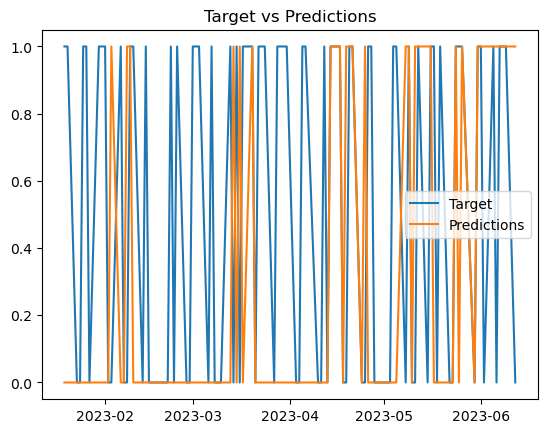

In [130]:
# Predictions Target Concatenation
preds = pd.Series(preds, index = test.index)
predsTarget = pd.concat([test["Target"], preds], axis = 1)

# Plot Accuracy
predsTarget.plot(kind = "line")
plt.title("Target vs Predictions")
plt.legend(["Target", "Predictions"])
plt.show()

In [131]:
# Predict Function
def predict(train, test, predictors, model) :
    model.fit(train[predictors], train["Target"]) # Model
    preds = model.predict(test[predictors]) # Predictions
    preds = pd.Series(preds, index = test.index, name = "Predictions") # Predictions
    predsTarget = pd.concat([test["Target"], preds], axis = 1) # Predictions Target Concatenation
    return predsTarget

In [132]:
# Backtest Function
def backtest(data, predictors, model, start = 2500, step = 250) : # 1yr = 250
    allPredictions = []
    
    for i in range(start, data.shape[0], step) :
        train = data.iloc[0:i].copy() # Train
        test = data.iloc[i:(i+step)].copy() # Test
        predictions = predict(train, test, predictors, model) # Predict Function
        allPredictions.append(predictions) # Append Predictions
    return pd.concat(allPredictions)

In [133]:
# Predictions Frequency
predictions = backtest(sp500, predictors, model)
predictions["Predictions"].value_counts()

0    3385
1    2541
Name: Predictions, dtype: int64

In [134]:
# Model Accuracy
score = precision_score(predictions["Target"], predictions["Predictions"])
print(f"1 = {score.round(2)}")

1 = 0.53


In [135]:
# True Outcome
(predictions["Target"].value_counts() / predictions["Predictions"].shape[0]).round(2)

1    0.53
0    0.47
Name: Target, dtype: float64

In [136]:
# History Function
horizons = [2, 5, 60, 250, 1000]
newPredictors = []

for horizon in horizons : 
    rollAvgs = sp500.rolling(horizon).mean()
    
    ratio = f"{horizon} Day Close Ratio"
    sp500[ratio] = sp500["Close"] / rollAvgs["Close"]
    
    trend = f"{horizon} Day Trend"
    sp500[trend] = sp500.shift(1).rolling(horizon).sum()["Target"]
    
    newPredictors += [ratio, trend]

In [137]:
# Remove Nulls
sp500 = sp500.dropna()
sp500

,Open,High,Low,Close,Volume,Tomorrow,Target,2 Day Close Ratio,2 Day Trend,5 Day Close Ratio,5 Day Trend,60 Day Close Ratio,60 Day Trend,250 Day Close Ratio,250 Day Trend,1000 Day Close Ratio,1000 Day Trend
1993-12-14,465.730011,466.119995,462.459991,463.059998,275050000,461.839996,0,0.997157,1.0,0.996617,1.0,1.000283,32.0,1.028047,127.0,1.176082,512.0
1993-12-15,463.059998,463.690002,461.839996,461.839996,331770000,463.339996,1,0.998681,0.0,0.995899,1.0,0.997329,32.0,1.025151,126.0,1.172676,512.0
1993-12-16,461.859985,463.980011,461.859985,463.339996,284620000,466.380005,1,1.001621,1.0,0.999495,2.0,1.000311,32.0,1.028274,127.0,1.176163,513.0
1993-12-17,463.339996,466.380005,463.339996,466.380005,363750000,465.850006,0,1.003270,2.0,1.004991,3.0,1.006561,32.0,1.034781,128.0,1.183537,514.0
1993-12-20,466.380005,466.899994,465.529999,465.850006,255900000,465.299988,0,0.999431,1.0,1.003784,2.0,1.005120,32.0,1.033359,128.0,1.181856,513.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-06-05,4282.990234,4299.279785,4266.819824,4273.790039,3813290000,4283.850098,1,0.998997,1.0,1.009754,3.0,1.043855,32.0,1.075880,115.0,1.134859,534.0
2023-06-06,4271.339844,4288.330078,4263.089844,4283.850098,3996560000,4267.520020,0,1.001176,1.0,1.008398,3.0,1.044517,33.0,1.078279,115.0,1.137109,534.0
2023-06-07,4285.470215,4299.189941,4263.959961,4267.520020,4537800000,4293.930176,1,0.998090,1.0,1.000424,3.0,1.038797,33.0,1.074004,115.0,1.132369,533.0
2023-06-08,4268.689941,4298.009766,4261.069824,4293.930176,3826740000,4298.859863,1,1.003085,1.0,1.003186,3.0,1.043639,33.0,1.080351,116.0,1.138963,533.0


In [138]:
# Model
model = RandomForestClassifier(n_estimators = 200, min_samples_split = 50, random_state = 1)

In [139]:
# Predict Function
def predict(train, test, predictors, model) :
    model.fit(train[predictors], train["Target"]) # Model
    preds = model.predict_proba(test[predictors]) [:,1] # Predictions Probability
    preds[preds >= 0.6] = 1 # Probability Level
    preds[preds < 0.6] = 0 # Probability Level
    preds = pd.Series(preds, index = test.index, name = "Predictions") # Predictions
    predsTarget = pd.concat([test["Target"], preds], axis = 1) # Predictions Target Concatenation
    return predsTarget

In [140]:
# Predictions Frequency
predictions = backtest(sp500, newPredictors, model)
predictions["Predictions"].value_counts()

0.0    4111
1.0     814
Name: Predictions, dtype: int64

In [141]:
# Model Accuracy
score = precision_score(predictions["Target"], predictions["Predictions"])
print(f"1 = {score.round(2)}")

1 = 0.57


In [142]:
# True Outcome
(predictions["Target"].value_counts() / predictions["Predictions"].shape[0]).round(2)

1    0.54
0    0.46
Name: Target, dtype: float64

# Conclusion
My model correctly predicted the sp500 Index would go up 57% of the days, while the sp500 Index went up 54% of the days. Therefore, we can conlude the model has 3% predictive ability compared to the sp500 Index. The next steps for this model would be to implement additional features such as market sentiment, sector performance, or company fundamentals to improve model accuracy